In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

import yfinance as yf

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import shapiro

## Get Data

In [2]:
# get data
df = yf.download('SPY','2010-10-01','2022-12-31', interval='1d')
# keep date variable
df.reset_index(inplace=True)

[*********************100%***********************]  1 of 1 completed


## Calc 

In [3]:
# calc simple moving average
df['High_sma_fast'] = df['High'].rolling(9).mean()

# remove missing valyes
df.dropna(inplace=True)


# calc ratio
df['High_actual_sma_ratio'] = df['High'] / df['High_sma_fast']
# calc log of ratio
df['High_actual_sma_ratio_log'] = np.log(df['High'] / df['High_sma_fast'])
# calc pct 
df['High_actual_sma_pct'] = (df['High'] - df['High_sma_fast']) / df['High_sma_fast']

# trim top and bottom 5%
# max_ = df['High_actual_sma_pct'].quantile(.95)
# min_ = df['High_actual_sma_pct'].quantile(.05)

# df = df[(df['High_actual_sma_pct'] > min_) & (df['High_actual_sma_pct'] < max_)].copy()

df.reset_index(inplace=True, drop=True)

### Bootstrap

In [4]:
# calculate the bootstap means
iterations = 1000
High_actual_sma_pct_bootstrapped = []
for _ in range(iterations):
    High_actual_sma_pct_bootstrapped.append(
                np.random.choice(df['High_actual_sma_pct'], 
                                 replace = True, 
                                 size = iterations
                                ).mean())

### Inspect

In [5]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume,High_sma_fast,High_actual_sma_ratio,High_actual_sma_ratio_log,High_actual_sma_pct
count,3057.000000,3057.000000,3057.000000,3057.000000,3057.000000,3.057000e+03,3057.000000,3057.000000,3057.000000,3057.000000
mean,247.184125,248.541914,245.701629,247.220389,227.951400,1.117806e+08,248.164533,1.001672,0.001567,0.001672
std,95.633698,96.276042,94.909911,95.629881,102.606157,6.473329e+07,96.176103,0.014310,0.014432,0.014310
min,108.349998,112.580002,107.430000,109.930000,89.164886,2.027000e+07,115.825555,0.897558,-0.108078,-0.102442
25%,174.910004,175.839996,174.110001,175.149994,148.282318,6.847120e+07,174.231110,0.995774,-0.004235,-0.004226
50%,218.389999,218.910004,217.919998,218.509995,195.678116,9.500080e+07,218.667775,1.003237,0.003232,0.003237
75%,297.549988,298.779999,295.920013,297.510010,283.119263,1.359354e+08,297.847775,1.009705,0.009658,0.009705
max,479.220001,479.980011,476.059998,477.709991,472.242310,7.178287e+08,477.615557,1.061999,0.060153,0.061999


<AxesSubplot:>

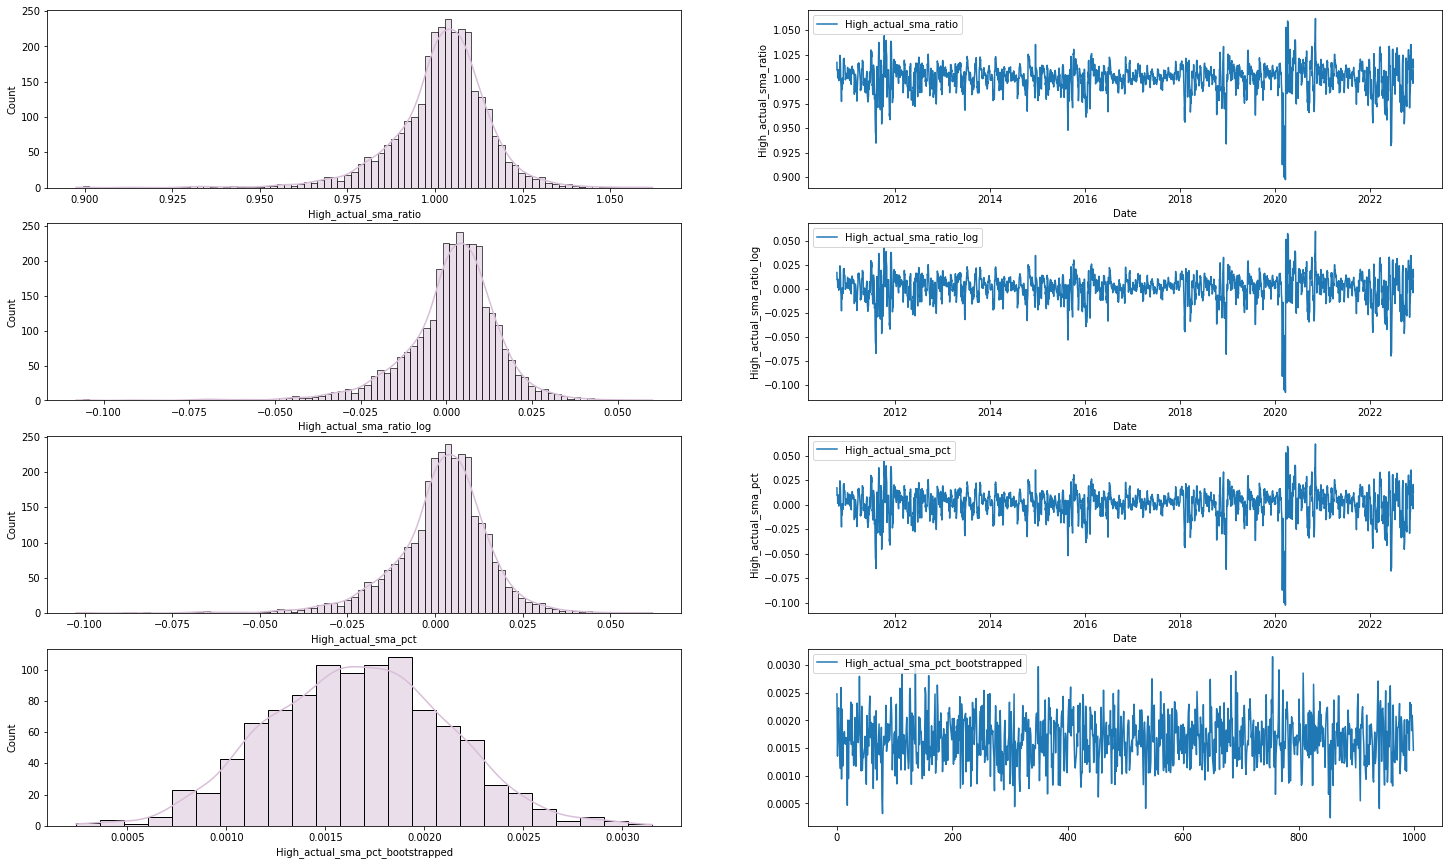

In [6]:
fig = plt.figure(figsize=(25,15))

plt.subplot(4,2,1)
sns.histplot(df['High_actual_sma_ratio'], color= 'thistle', kde=True).set(xlabel='High_actual_sma_ratio')
plt.subplot(4,2,2)
sns.lineplot(x=df['Date'],y=df['High_actual_sma_ratio'], label='High_actual_sma_ratio')

plt.subplot(4,2,3)
sns.histplot(df['High_actual_sma_ratio_log'], color= 'thistle', kde=True).set(xlabel='High_actual_sma_ratio_log')
plt.subplot(4,2,4)
sns.lineplot(x=df['Date'],y=df['High_actual_sma_ratio_log'], label='High_actual_sma_ratio_log')

plt.subplot(4,2,5)
sns.histplot(df['High_actual_sma_pct'], color= 'thistle', kde=True).set(xlabel='High_actual_sma_pct')
plt.subplot(4,2,6)
sns.lineplot(x=df['Date'],y=df['High_actual_sma_pct'], label='High_actual_sma_pct')

plt.subplot(4,2,7)
sns.histplot(High_actual_sma_pct_bootstrapped, color= 'thistle', kde=True).set(
                                        xlabel='High_actual_sma_pct_bootstrapped')
plt.subplot(4,2,8)
sns.lineplot(x=range(0,len(High_actual_sma_pct_bootstrapped)),
                     y=High_actual_sma_pct_bootstrapped, label='High_actual_sma_pct_bootstrapped')


## Normality Test

In [7]:
# Shapiro-Wilk Test

# normality test
stat, p = shapiro( High_actual_sma_pct_bootstrapped) 
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=0.999, p=0.684
Sample looks Gaussian (fail to reject H0)


## Write Function

In [8]:

def create_bootstrapped_mean_sma_spread(df, ticker ,start_dt,end_dt, interval):
    df = df[(df['Date']>= start_dt ) & (df['Date'] <= end_dt)].copy()
    df.reset_index(inplace=True)
    # calc simple moving average
    df['High_sma_fast'] = df['High'].rolling(9).mean()
    # remove missing valyes
    df.dropna(inplace=True)
    # calc ratio
    df['High_actual_sma_ratio'] = df['High'] / df['High_sma_fast']
    # calc log of ratio
    df['High_actual_sma_ratio_log'] = np.log(df['High'] / df['High_sma_fast'])
    # calc pct 
    df['High_actual_sma_pct'] = (df['High'] - df['High_sma_fast']) / df['High_sma_fast']
    
    # calculate the bootstap means
    iterations = 1000
    High_actual_sma_pct_bootstrapped = []
    for _ in range(iterations):
        High_actual_sma_pct_bootstrapped.append(
                    np.random.choice(df['High_actual_sma_pct'], 
                                     replace = True, 
                                     size = iterations
                                    ).mean())
    data =  { "Ticker": ticker,
             "Start_Date": start_dt,
             "End_Date": end_dt,
             "Interval": interval,
             "boostapped": [High_actual_sma_pct_bootstrapped],
             "boostappedMean": np.mean(High_actual_sma_pct_bootstrapped),
             'ClosingPrice': list(df['Close'])[-1]
         }
    
    return data


## Simulation

In [38]:
# set variables

ticker = 'SPY'
start_dt = '2010-10-01'
end_dt = '2022-12-31'
interval = '1d'

# number of records between start and end date used for bootstrap datatset
N = 200

# number of days between sampling 
M = 7

# get data
df = yf.download(ticker ,start_dt,end_dt, interval=interval)
# keep date variable
df.reset_index(inplace=True)


# get range of dates
datelist = pd.date_range(datetime(2018, 1, 1), datetime(2022, 12, 1)).tolist()

# define start and end dates
datelist_start = [str(x)[:10] for x in datelist]
datelist_end = datelist_start[N:]

# create dataframe of dates
dates = pd.DataFrame(datelist_start[:-N], columns=['start_dt'])
dates['end_date'] = datelist_end


# create sample of bootstapp mean sma_high spead
output = []
for i in range(0,len(dates),M):
    ticker = 'SPY'
    start_dt = dates['start_dt'][i]
    end_dt = dates['end_date'][i]
    interval = '1d'
    
    data = create_bootstrapped_mean_sma_spread(df, ticker ,start_dt,end_dt, interval)
    output.append(data)
    print("Round {} out of {} total.".format(i//M+1, len(dates)//M))

    
data = pd.DataFrame(output)
data['End_Date'] = pd.to_datetime(data['End_Date'])
data['Start_Date'] = pd.to_datetime(data['Start_Date'])


[*********************100%***********************]  1 of 1 completed
Round 1 out of 228 total.
Round 2 out of 228 total.
Round 3 out of 228 total.
Round 4 out of 228 total.
Round 5 out of 228 total.
Round 6 out of 228 total.
Round 7 out of 228 total.
Round 8 out of 228 total.
Round 9 out of 228 total.
Round 10 out of 228 total.
Round 11 out of 228 total.
Round 12 out of 228 total.
Round 13 out of 228 total.
Round 14 out of 228 total.
Round 15 out of 228 total.
Round 16 out of 228 total.
Round 17 out of 228 total.
Round 18 out of 228 total.
Round 19 out of 228 total.
Round 20 out of 228 total.
Round 21 out of 228 total.
Round 22 out of 228 total.
Round 23 out of 228 total.
Round 24 out of 228 total.
Round 25 out of 228 total.
Round 26 out of 228 total.
Round 27 out of 228 total.
Round 28 out of 228 total.
Round 29 out of 228 total.
Round 30 out of 228 total.
Round 31 out of 228 total.
Round 32 out of 228 total.
Round 33 out of 228 total.
Round 34 out of 228 total.
Round 35 out of 228 to

In [39]:
data_200 = data.copy()
data_200 = data_200[['Ticker','End_Date','boostappedMean','ClosingPrice']].copy()


In [40]:
data_20['Type'] = 'data_20'
data_100['Type'] = 'data_100'
data_200['Type'] = 'data_200'

In [41]:
data_200.rename(columns={'boostappedMean':'boostappedMean_200SMA'}, inplace=True)
data_100.rename(columns={'boostappedMean':'boostappedMean_100SMA'}, inplace=True)
data_20.rename(columns={'boostappedMean':'boostappedMean_20SMA'}, inplace=True)

In [50]:
data_20['fast_diff'] =  data_20['boostappedMean_20SMA'] - data_100['boostappedMean_100SMA']

<AxesSubplot:xlabel='End_Date'>

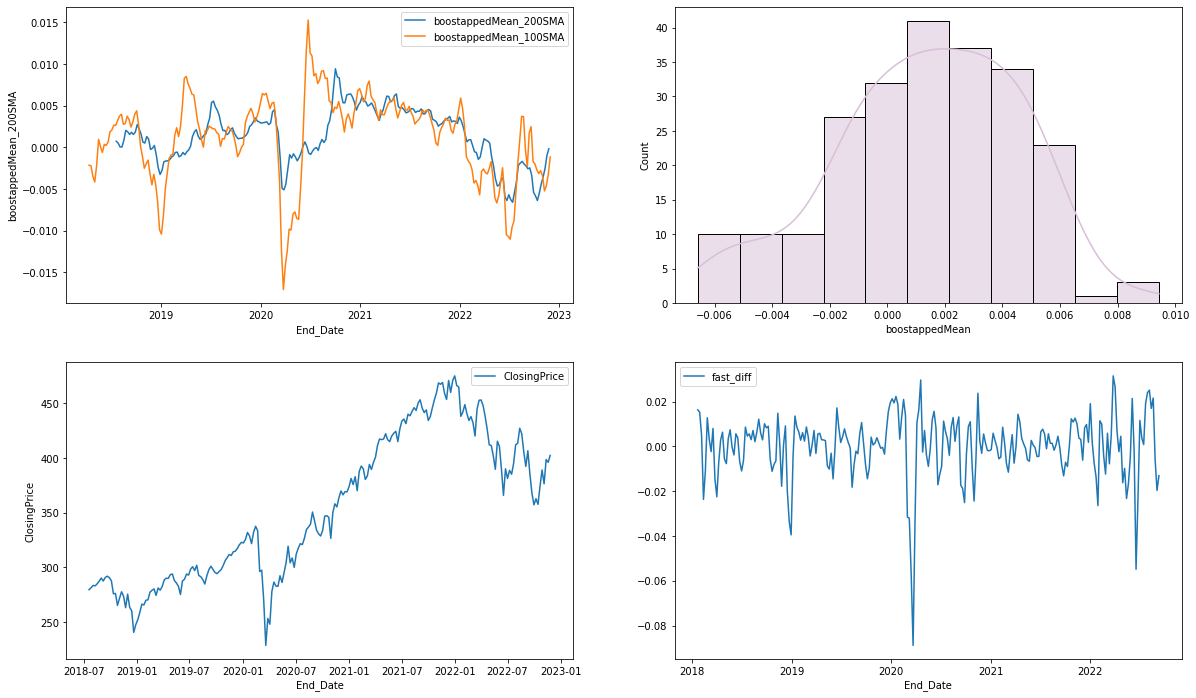

In [47]:
fig = plt.figure(figsize=(20,12))

plt.subplot(2,2,2)
sns.histplot(data['boostappedMean'], color= 'thistle', kde=True).set(xlabel='boostappedMean')
plt.subplot(2,2,1)
sns.lineplot(x=data_200['End_Date'],y=data_200['boostappedMean_200SMA'], label='boostappedMean_200SMA')
sns.lineplot(x=data_100['End_Date'],y=data_100['boostappedMean_100SMA'], label='boostappedMean_100SMA')
#sns.lineplot(x=data_20['End_Date'],y=data_20['boostappedMean_20SMA'], label='boostappedMean_100SMA')

plt.subplot(2,2,3)
sns.lineplot(x=data['End_Date'],y=data['ClosingPrice'], label='ClosingPrice')
plt.subplot(2,2,4)
sns.lineplot(x=data_20['End_Date'],y=data_20['fast_diff'], label='fast_diff')


In [56]:

data_20[data_20['End_Date']>'2022-01-01'].sort_values('fast_diff').dropna().head()


,Ticker,End_Date,boostappedMean_20SMA,ClosingPrice,Type,fast_diff
230,SPY,2022-06-19,-0.057179,365.859985,data_20,-0.054874
210,SPY,2022-01-30,-0.028992,441.950012,data_20,-0.026427
231,SPY,2022-06-26,-0.021833,390.079987,data_20,-0.023577
225,SPY,2022-05-15,-0.025185,401.720001,data_20,-0.023252
241,SPY,2022-09-04,-0.022895,392.239990,data_20,-0.019669
